In [1]:
from pypt.pmv import PMV, solvers_qp
from pypt.load_data import get_data


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style('white')
sns.set_context("paper", font_scale = 2)


In [2]:
# returns = get_data(symbols=["MSFT","MA","IPB","JPM","MSCI"],start_date="2017-01-01",end_date="2021-01-01",
#                     frequency="M").returns(return_type = 'log')
# returns_indice = get_data(symbols=["^GSPC"],start_date="2017-01-01",end_date="2021-01-01",
#                     frequency="M").returns(return_type = 'log')

In [3]:
returns = pd.read_excel("./datasets/parcial2.xlsx")
returns_indice = pd.read_excel("./datasets/parcial2_indice.xlsx")

# Primer punto

In [4]:

vcov = np.array(returns.cov())
mu = returns.agg(np.mean)
rf = 0

### Con cortos
pmvg = PMV(returns=returns).mv().pmv
psharpe = PMV(returns=returns).sharpe().psharpe
psortino = PMV(returns=returns).sortino(rf = 0, cortos = True).psortino
ptreynor = PMV(returns=returns).treynor(index_returns=returns_indice.iloc[:,0]).ptreynor

### Sin cortos 
pmvg_sc = solvers_qp(vcov=vcov,mu=mu, optimal_portfolio=pmvg[0],inequality=True)
psharpe_sc = solvers_qp(vcov=vcov,mu=mu, optimal_portfolio=psharpe[0],inequality=True)
psortino_sc = solvers_qp(vcov=vcov,mu=mu, optimal_portfolio=psortino[0],inequality=True) 
ptreynor_sc = solvers_qp(vcov=vcov,mu=mu, optimal_portfolio=[ptreynor[0]],inequality=True)


## Portafolio Omega sin cortos (Obtenido de R)
pomega_sc = [0.401295,0,0,0,0.598705]



## ## Retorno, riesgo y ratio de sharpe
Er = []
Rr = []
sharpe_ratio = []
for model in ([pmvg_sc,psharpe_sc,ptreynor_sc,psortino_sc,pomega_sc]):
    Rp = (returns @ model).mean()
    Sigmap = (returns @ model).std()

    Ratio = (Rp - rf)/Sigmap
    sharpe_ratio.append(Ratio)
    Er.append(Rp)
    Rr.append(Sigmap)

## Sortino ratio
sortino_ratio = []
for model in ([psortino_sc]):
    Rp = returns @ model
    Rp_rf = np.array([i-rf if i >= 0 else 0 for i in Rp ])
    Excess_return = Rp_rf**2
    
    ns = len(Excess_return)
    Sigma_sortino = np.sqrt(Excess_return.sum()/ns)
    Ratio = (Rp-rf)/Sigma_sortino
    sortino_ratio.append(Ratio[0])


## Omega ratio
omega_ratio = []
for model in ([pomega_sc]):
    Rp = returns @ model
    Excess_return =  pd.Series([i-j for i,j in zip(Rp,returns_indice.iloc[:,0])])
    winning = Excess_return[Excess_return>0]
    loosing = Excess_return[Excess_return<0]
    Ratio = winning.sum()/np.abs(loosing.sum())
    omega_ratio.append(Ratio)

pd.DataFrame({
    "Retorno" : Er,
    "Riesgo": Rr,
    "Ratio de Sharpe": sharpe_ratio,
    "Ratio de sortino": [None,None,None,sortino_ratio[0],None],
    "Ratio omega": [None,None,None,None,omega_ratio[0]]
}, index = ["PMVg","Sharpe","Treynor","Sortino","Omega"]).T



,PMVg,Sharpe,Treynor,Sortino,Omega
Retorno,0.010801,0.030613,0.026911,0.023101,0.033142
Riesgo,0.029046,0.047294,0.042079,0.037280,0.051640
Ratio de Sharpe,0.371877,0.647282,0.639521,0.619659,0.641798
Ratio de sortino,NaN,NaN,NaN,0.882348,NaN
Ratio omega,NaN,NaN,NaN,NaN,5.138617


## Análisis del Ratio de Sharpe

Para los portafolios de Treynor, Sortino y Omega usando el ratio de Sharpe podemos concluir que el portafolio de Sortino permite obtener un mayor retorno con una menor exposición al riesgo

## Ratio de Sharpe vs Ratio de Sortino vs Ratio Omega

Para entender la diferencia entre estas tres métricas de evaluación debemos pensar que tipo de riesgo queremos medir. Mientras que el ratio de Sharpe compara el exceso de ratorno dado la volatilidad del portafolio, El ratio de Sortino compara el exceso de retorno dada la "volatilidad negativa" del portafolio, por último, el ratio Omea nos permite ver la ponderación entre las ganancias y las pérdidas del portafolio dado un benchmark.


# Punto 2

In [5]:
# Risk-Parity Portfolio (Obtenido de R)
rpp_vanilla = [0.2045394, 0.1282664, 0.3660611, 0.1379430, 0.1631902 ]
cvar = [0.71756, 0.00000, 0.28244, 0.00000, 0.00000 ]

# Punto 3

Distribuciónes de probabilidades del retorno de las acciones

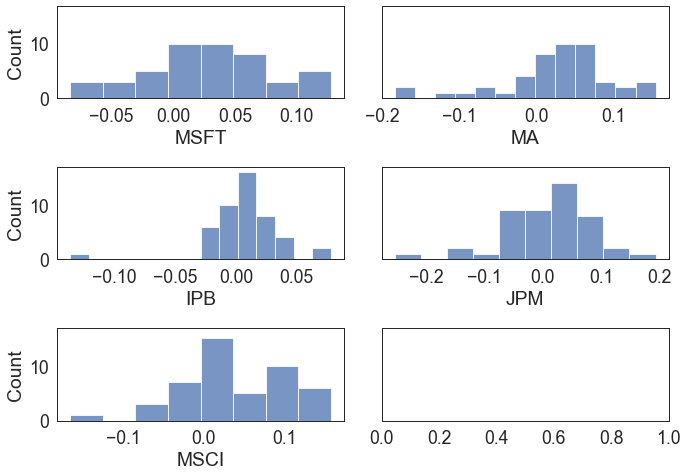

In [6]:
fig, axes = plt.subplots(3,2,figsize=(10,7), sharey=True)
for i,rc in zip(returns,[(0,0),(0,1),(1,0),(1,1),(2,0)]):
    ax = sns.histplot(ax=axes[rc[0],rc[1]],x=returns[i])
plt.tight_layout()
plt.show()

In [7]:
from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

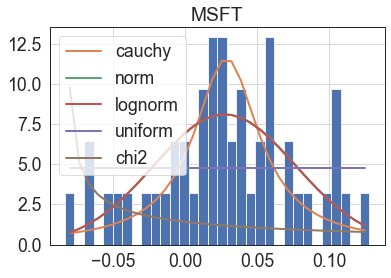

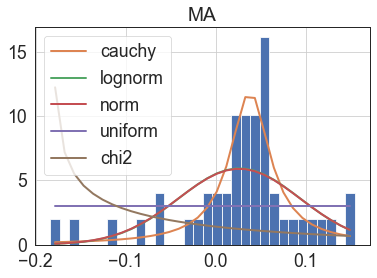

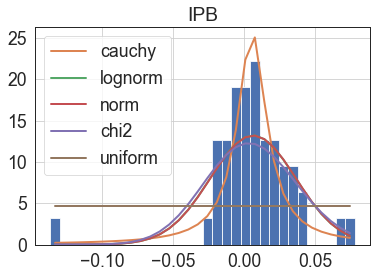

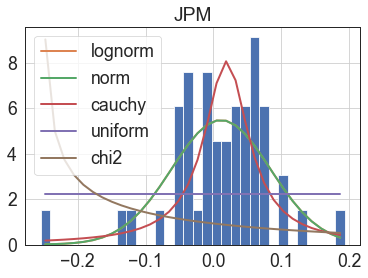

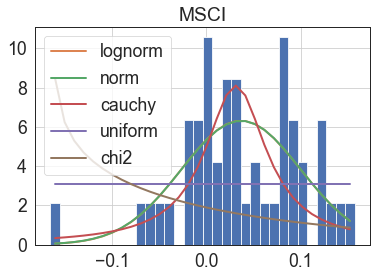

In [29]:
n = returns.shape[0]
fig = plt.figure()
dists = pd.DataFrame({})
for i,rc in zip(returns,[(0,0),(0,1),(1,0),(1,1),(2,0)]):
    f = Fitter(returns[i],distributions=["norm","lognorm","uniform","cauchy","chi2"], bins=32 )
    f.fit()
    df_temp = f.summary(plot=True)
    df_temp.insert(0,"Asset",i)
    dists = pd.concat([dists,df_temp],axis=0)
    plt.title(f'{i}')
    plt.show(block=False)


In [40]:
best_dists = pd.DataFrame({})
for i in dists['Asset'].unique():
    df_temp = dists[dists['Asset']==i]
    df_temp = df_temp.iloc[0,:]
    best_dists = pd.concat([best_dists,df_temp],axis=1)

In [41]:
best_dists

,cauchy,cauchy,cauchy,lognorm,lognorm
Asset,MSFT,MA,IPB,JPM,MSCI
sumsquare_error,308.006316,113.209853,248.737092,101.753155,174.899458
aic,-60.176092,-10.208508,-26.316813,8.685407,-28.648988
bic,96.059012,49.017788,86.013993,47.853348,73.311436
kl_div,inf,inf,inf,inf,inf


De acuerdo al punto anterior, en nuestros modelos hemos asumido que todos los activos presentan una distribución normal, esto que hace que resultados relevantes como el primer y segundo momento que serían nuestro retorno y volatilidad, respectivamente, asuman normalidad. No obstante como poudimos observar no necesariamente el retorno de los activos prsenta ea distribución, por ejemplo MSFT, MA, e IPB se asimilan más a una distribución cauchy donde po definición no se puede asumir una media o una varianza 